# Plots
<hr style="clear:both">

This notebook presents and displays our plot illustrating out story.


**Project Mentor:** [Shuo Wen](http://personnes.epfl.ch/shuo.wen) ([Email](shuo.wen@epfl.ch)),
**Authors:** Mahmoud Dokmak, Matthieu Borello, Léo Brunneau, Loïc Domingos, Bastien Armstrong

<hr style="clear:both">

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import scipy.stats as stats
from dash.dependencies import Input, Output
import dash
from dash import dcc, html
import warnings
warnings.filterwarnings('ignore')
from ipywidgets import interact
from src.utils.results_utils import *

In [121]:
movies = pd.read_pickle('./data/Success_Metric.pkl')
movies.head()

,freebase_movie_id,imdb_id,item_id,movie_name,combined_release_date,Box_Office,inflation_adjusted_box_office_revenue,movie_countries_final,movie_genres_final,sa_score,popularity,rating,success_score,success_metric_scaled
30973,/m/083skw,031381,NaN,Gone with the Wind,1939-12-15,0.143767,0.996126,United States of America,"[Film adaptation, Costume drama, Roadshow thea...",0.619947,1.0,0.785789,22.186218,5.000000
9888,/m/0k4d7,029583,NaN,Snow White and the Seven Dwarfs,1937-12-21,0.149518,1.000000,United States of America,"[Romance Film, Musical, Fantasy, Family Film, ...",0.619947,1.0,0.696421,21.949103,4.944015
1036,/m/04j1zjw,034492,NaN,Bambi,1942-08-14,0.096125,0.567962,United States of America,"[Adventure, Children's/Family, Animation, Comi...",0.619947,1.0,0.684211,18.456170,4.119294
66323,/m/0dtfn,076759,NaN,Star Wars Episode IV: A New Hope,1977-05-25,0.278692,0.442916,United States of America,"[Science Fiction, Adventure, Fantasy, Coming o...",0.619947,1.0,0.810947,17.836009,3.972866
18216,/m/0dr_4,120338,1721.0,Titanic,1997-11-18,0.785462,0.471324,United States of America,"[Tragedy, Costume drama, Historical fiction, A...",0.592075,1.0,0.714080,17.689057,3.938169


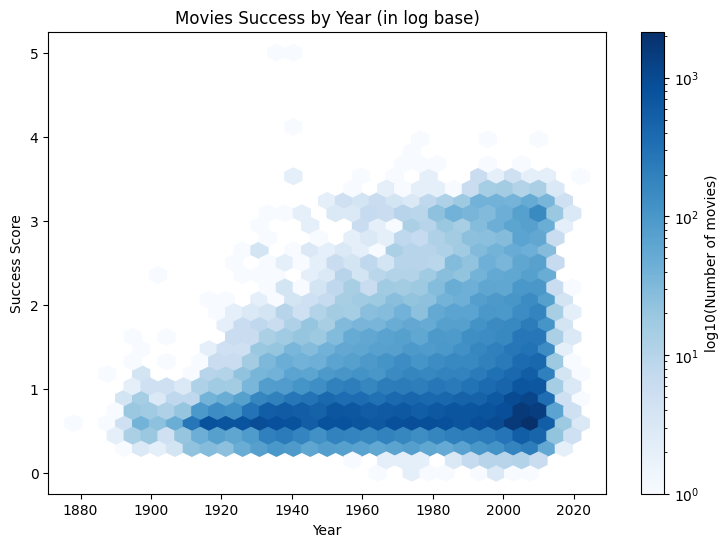

In [122]:
# Hexbin plot
# Create a copy to not modify our final dataframe
# Keeping only the year as we are looking at year distribution
success_by_year = movies.copy()
success_by_year['year'] = pd.to_datetime(success_by_year['combined_release_date']).dt.year
plt.figure(figsize=(9, 6))
plt.hexbin(success_by_year['year'], success_by_year['success_metric_scaled'],gridsize=30,cmap='Blues',bins='log')
plt.colorbar(label='log10(Number of movies)')

# Set the title and labels
plt.xlabel('Year')
plt.ylabel('Success Score')
plt.title('Movies Success by Year (in log base)')

plt.savefig('plots/movie_success_hexbin.png', dpi=300, bbox_inches='tight')
plt.show()

This plot represent the distribution of the success metric assigned to the movies.

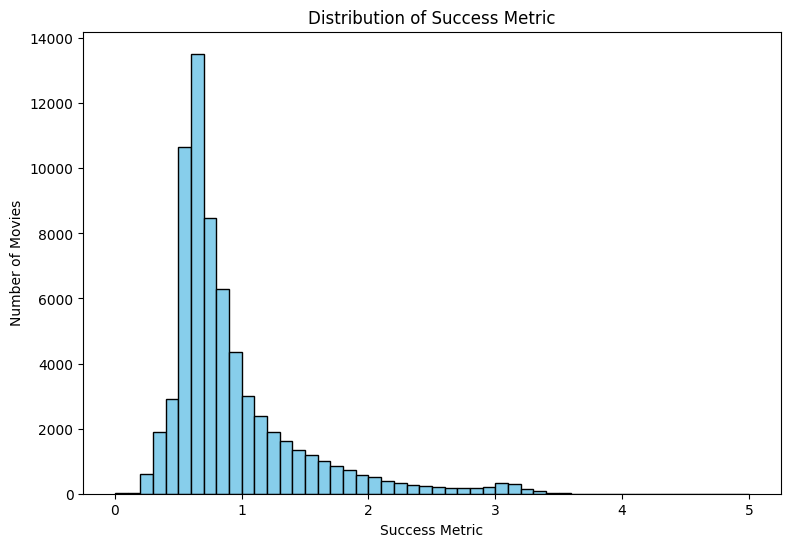

In [123]:
movies.head(10)
# Create a histogram of the Success_metric
plt.figure(figsize=(9, 6))
plt.hist(movies['success_metric_scaled'].dropna(), bins=50, color='skyblue', edgecolor='black')

# Set the title and labels
plt.title('Distribution of Success Metric')
plt.xlabel('Success Metric')
plt.ylabel('Number of Movies')

# Show the plot
plt.savefig('plots/success_metric_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

In [124]:
# Line plot
# Keeping only the year as we are looking at year distribution
movies['year'] = pd.to_datetime(movies['combined_release_date']).dt.year
# Explode the genres to have one genre per row to be able to count them
movies['movie_genres_final'] = movies['movie_genres_final'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
n_genre_per_year = movies.explode('movie_genres_final')
# Keep only the top 20 genres
genre_counts = n_genre_per_year['movie_genres_final'].value_counts()
best_genres = genre_counts.head(20).index.tolist()
n_genre_per_year = n_genre_per_year[n_genre_per_year['movie_genres_final'].isin(best_genres)]
# Ensure the order of the genres
n_genre_per_year['movie_genres_final'] = pd.Categorical(n_genre_per_year['movie_genres_final'],categories=best_genres, ordered=True)
# Count the number of movies per genre per year
n_genre_per_year = n_genre_per_year.groupby(['year', 'movie_genres_final']).size().reset_index(name='movie_count')

In [125]:
# Generate the line plot as before
fig = px.line(n_genre_per_year, x='year', y='movie_count', color='movie_genres_final',
              title='Top 15 Movies Count by Genre Over Time',
              labels={'year': 'Release Year', 'movie_count': 'Number of Movies', 'movie_genres_final': 'Genres'},
              )

# Update layout to set white background
fig.update_layout(
    paper_bgcolor='white',  # Set the overall figure background color to white
    legend=dict(itemclick="toggleothers")  # Allow toggling of the genres in the legend
)

# Show the plot
fig.write_html('plots/movie_counts_by_genre.html', full_html=True)
fig.show()

In [126]:
# Line plot
# Keeping only the year as we are looking at year distribution
movies['year'] = pd.to_datetime(movies['combined_release_date']).dt.year
# Explode the genres to have one genre per row to be able to count them
movies['movie_genres_final'] = movies['movie_genres_final'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
n_genre_per_year = movies.explode('movie_genres_final')
# Keep only the top 20 genres
genre_counts = n_genre_per_year['movie_genres_final'].value_counts()
best_genres = ['Silent film', 'War film', 'Black-and-white', 'Western']
n_genre_per_year = n_genre_per_year[n_genre_per_year['movie_genres_final'].isin(best_genres)]
# Ensure the order of the genres
n_genre_per_year['movie_genres_final'] = pd.Categorical(n_genre_per_year['movie_genres_final'],categories=best_genres, ordered=True)
# Count the number of movies per genre per year
n_genre_per_year = n_genre_per_year.groupby(['year', 'movie_genres_final']).size().reset_index(name='movie_count')

In [127]:
fig = px.line(n_genre_per_year, x='year', y='movie_count', color='movie_genres_final',
              title='Movie Counts for Selected Genres Over Time',
              labels={'year': 'Release Year', 'movie_count': 'Number of Movies', 'movie_genres_final': 'Genres'},
              )

# Update layout to set white background
fig.update_layout(
    paper_bgcolor='white',  # Set the overall figure background color to white
    legend=dict(itemclick="toggleothers")  # Allow toggling of the genres in the legend
)

# Show the plot
fig.write_html('plots/movie_counts_by_genre_subset.html', full_html=True)
fig.show()

In [128]:
# Histogram
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=movies['success_metric_scaled'],
    nbinsx=75,
    marker_color='skyblue',
    opacity=0.7
))

fig.update_layout(
    title='Success Score Distribution',
    xaxis_title='Success Score',
    yaxis_title='Number of Movies',
    template='plotly_white',
    hovermode='closest',
    yaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=4000,
        tickformat='d',
    ),
)

fig.write_html('plots/success_score_distribution.html', full_html=False)
fig.show()


In [129]:
# Donut chart
# Movies have more than one genre, so we need to explode the genres to count them
movies_pie_df = movies.copy()
movies_pie_df['movie_genres_final'] = movies_pie_df['movie_genres_final'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])
genre_per_film = movies.explode('movie_genres_final')
# Put the genres that are not in the top 20 represented in our dataframe in the "Others" category
n_genres = genre_per_film['movie_genres_final'].value_counts()
top_20_genres = n_genres.head(20).index.tolist()
genre_per_film['movie_genres_final'] = genre_per_film['movie_genres_final'].apply(lambda x: x if x in top_20_genres else 'Others')
# Recalculate the number of movies per genre with the new "Others" category
n_genres = genre_per_film['movie_genres_final'].value_counts().reset_index()
n_genres.columns = ['Genre', 'Count']
fig = px.pie(
    n_genres,
    names='Genre',
    values='Count',
    title='Distribution of Number of Movies by Genre',
    hole=0.4
)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(showlegend=True, height=600)

fig.write_html('plots/genre_piechart.html', full_html=False)
fig.show()

In [130]:
# Precompute datasets
def compute_country_success(movies, top_n=None):
    all_countries_per_film = movies.explode('movie_countries_final')
    if top_n:
        country_success = all_countries_per_film.groupby('movie_countries_final', group_keys=False)\
            .apply(lambda x: x.nlargest(top_n, 'success_metric_scaled'))\
            .groupby('movie_countries_final')['success_metric_scaled'].mean().reset_index()
    else:
        country_success = all_countries_per_film.groupby('movie_countries_final')['success_metric_scaled'].mean().reset_index()
    return country_success

# Precompute data for different top N values
datasets = {
    f"Top {n}": compute_country_success(movies, n)
    for n in [10, 50, 100, 200, 500]
}
datasets['All Movies'] = compute_country_success(movies, None)

# Define the color range explicitly (0 to 5)
color_min, color_max = 0, 5

# Create the initial figure (default view: Top 10)
initial_data = datasets["Top 10"]
fig = px.choropleth(
    initial_data,
    locations='movie_countries_final',
    locationmode='country names',
    color='success_metric_scaled',
    hover_name='movie_countries_final',
    color_continuous_scale='Blues',
    labels={'success_metric_scaled': 'Mean Success Metric'},
    title='World Map of Mean Success Score by Country (Top 10 Movies)'
)

# Update the color axis to fix the range
fig.update_layout(coloraxis_colorbar=dict(title="Success Metric"), coloraxis=dict(cmin=color_min, cmax=color_max))

# Add dropdown to switch datasets
dropdown_buttons = []
for label, data in datasets.items():
    button = {
        "label": label,
        "method": "update",
        "args": [
            {"z": [data['success_metric_scaled']], "locations": [data['movie_countries_final']]},
            {"title": f"World Map of Mean Success Score by Country ({label})"}
        ]
    }
    dropdown_buttons.append(button)

# Update layout to include the dropdown
fig.update_layout(
    updatemenus=[{
        "buttons": dropdown_buttons,
        "direction": "down",
        "showactive": True,
        "x": 0.1,
        "xanchor": "left",
        "y": 1.15,
        "yanchor": "top"
    }]
)

# Save to standalone HTML
fig.write_html("plots/precomputed_choropleth_fixed_colorbar.html")
fig.show()

Very beautiful plot to display the most successfull movies

In [131]:
# Sort movies by success
most_successful = movies.sort_values(by='success_metric_scaled', ascending=False)

# Precompute data for Top 5, 10, 50, and 100
precomputed_data = {
    'Top 5': most_successful.head(5),
    'Top 10': most_successful.head(10),
    'Top 25': most_successful.head(25),
    'Top 50': most_successful.head(50),
}

# Create a function to generate a bar chart
def plot_top_movies(data, title):
    fig = px.bar(data,
                 x='movie_name',
                 y='success_metric_scaled',
                 title=title,
                 labels={'movie_name': 'Movie', 'success_metric_scaled': 'Success Score'},
                 hover_data=['movie_name', 'success_metric_scaled', 'Box_Office', 'rating'],
                 color_discrete_sequence=['skyblue'])
    fig.update_layout(
        xaxis_title="Movie",
        yaxis_title="Success Metric",
        xaxis_tickangle=-45,
        height=600,
    )
    return fig

# Generate the initial figure for "Top 5"
initial_data = precomputed_data['Top 5']
fig = plot_top_movies(initial_data, "Top 5 Movies by Success Metric")

# Add buttons for interactivity
buttons = []
for label, data in precomputed_data.items():
    buttons.append(
        dict(
            label=label,
            method="update",
            args=[
                {"x": [data['movie_name']], "y": [data['success_metric_scaled']]},
                {"title": f"{label} Movies by Success Metric"}
            ]
        )
    )

# Update the figure layout to include the buttons
fig.update_layout(
    updatemenus=[{
        "buttons": buttons,
        "direction": "down",
        "showactive": True,
        "x": 0.1,
        "xanchor": "left",
        "y": 1.15,
        "yanchor": "top"
    }]
)

# Write to a standalone HTML file
fig.write_html("plots/top_movies.html")
fig.show()

In [ ]:
movies['movie_genres_final'] = movies['movie_genres_final'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
movies['release_year'] = pd.to_datetime(movies['combined_release_date']).dt.year
movies.sort_values(by='success_metric_scaled', ascending=False, inplace=True)
# This plot is by decade, by genre
movies['decade'] = movies['release_year'].apply(get_decade)
all_genres_per_film = movies.explode('movie_genres_final')

# Let's keep only the top 20
popular_genres = all_genres_per_film['movie_genres_final'].value_counts().head(20).index
popular_movies_genre = all_genres_per_film[all_genres_per_film['movie_genres_final'].isin(top_20_genres)]

# Compute the mean success score and the number of released movie by decade and genre
grouped = popular_movies_genre.groupby(['decade', 'movie_genres_final']).agg(
    count=('movie_genres_final', 'size'),
    mean_success_score=('success_metric_scaled', 'mean')
).reset_index()
grouped_sorted = grouped.sort_values(by='mean_success_score', ascending=False)

# Bubble chart
fig = px.scatter(
    grouped_sorted,
    x='decade',
    y='mean_success_score',
    size='count',
    color='movie_genres_final',
    hover_name='movie_genres_final',
    title='Mean Success Score & Number of Movies by Decade in the Top 20 Genres',
    labels={'decade': 'Decade', 'mean_success_score': 'Mean Success Score', 'count': 'Count'},
    size_max=50
)
fig.update_layout(
    xaxis_title="Decade",
    yaxis_title="Mean Success Score",
    legend_title="Genre",
    template="plotly",
    yaxis=dict(range=[0.5, 2]),
    height=600,
    legend=dict(itemclick="toggleothers")
)

fig.write_html("plots/genre_decade_bubble.html", full_html=True)
fig.show()